In [5]:
# python3
import gzip
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import re
from time import time
import pickle

### Loading Data

In [2]:
with gzip.open('Beeradvocate.txt.gz', 'r') as f:
  rb_file = f.readlines()


data = []
row_out = []
stop = stopwords.words('english')

for i in rb_file:
    row = i.decode('utf-8', errors = 'replace')
    #print(row)
    if row == '\n':
      data.append(row_out)
      row_out = []
      continue
    cat, field = row.split(":", 1)
    #remove leading white spaces
    field = field.rstrip()
    if cat == 'review/text':
        #remove tab and newspace characters
        field = field.replace('\t', ' ')
        field = field.replace('\n', '')
        
        #remove punctuation
        
        #field = field.translate(str.maketrans('','',string.punctuation)) #this can be used for python 3
        #field = field.translate(None, string.punctuation) #this has issues with unicode characters
        field = re.sub(r'[^\w\s]','',field) #slower but effective
        field = field.lower()
    row_out.append(field)

In [3]:
data = pd.DataFrame(data)

data.columns = ['beer_name', 'beer_beerId', 'beer_brewer', 'beer_ABV', 'beer_style', 
                'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 
                'review_overall', 'review_time', 'review_profileName', 'review_text']


corpus = data[['beer_beerId', 'review_text']].groupby('beer_beerId').agg(' '.join)
#sample = corpus.iloc[0:1000]

# TF-IDF

### Calculating TF-IDF scores for entire corpus

In [5]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stemmer = SnowballStemmer("english")
n_features = 500

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

t0 = time()

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_features = n_features)
tfidf = tfidf_vectorizer.fit_transform(corpus['review_text'])
print("done in %0.3fs." % (time() - t0))

done in 2730.904s.


https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [16]:
# save the model to disk
filename1 = 'tfidf.sav'
filename2 = 'tfidf_vec.sav'
pickle.dump(tfidf, open(filename1, 'wb'))
pickle.dump(tfidf_vectorizer, open(filename2, 'wb'))

### Load TF-IDF scores for entire corpus

In [8]:
filename1 = 'tfidf.sav'
filename2 = 'tfidf_vec.sav'
tfidf = pickle.load(open(filename1, 'rb'))
tfidf_vectorizer = pickle.load(open(filename2, 'rb'))

In [22]:
tfidf_map = {}

for i in range(len(corpus.index.values)):
    beer_id = corpus.index.values[i]
    tfidf_representation = tfidf[i]
    tfidf_map[beer_id] = tfidf_representation


In [19]:
test = corpus.iloc[1001]['review_text']
response = tfidf_vectorizer.transform([test])

feature_names = tfidf_vectorizer.get_feature_names()
for col in response.nonzero()[1]:
    print feature_names[col], ' - ', response[0, col]

worth  -  0.132289435872
weak  -  0.154088241374
version  -  0.152678808563
veri  -  0.215331917163
tri  -  0.212743348445
tast  -  0.0678432969964
sweet  -  0.0755959924884
surpris  -  0.128531190268
summer  -  0.159678560511
slight  -  0.172694031845
refresh  -  0.129654822652
quick  -  0.113697804939
price  -  0.174715567897
pour  -  0.074886136979
pack  -  0.169589965583
ok  -  0.145146601867
noth  -  0.121464360211
mouthfeel  -  0.166134746361
light  -  0.150226065941
label  -  0.145138346912
ive  -  0.123142704903
hue  -  0.135719797946
hot  -  0.158946026035
hint  -  0.0957592376478
head  -  0.0609862675123
got  -  0.129526428891
gold  -  0.136059505136
finish  -  0.0794027912669
fine  -  0.133140143708
fantast  -  0.173699031481
fade  -  0.259184309965
especi  -  0.151539116271
drinkabl  -  0.179823004406
clear  -  0.102573329634
clean  -  0.117518032029
cap  -  0.140703453935
came  -  0.155877402406
bottl  -  0.110277904416
bodi  -  0.0749501929524
best  -  0.120598180068
beer

# Training a linear model for each user

### Example with one user

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

t0 = time()

t_user = data.iloc[0]['review_profileName']
t_reviews = data[data['review_profileName'] == t_user]


#X = tfidf_map[t_reviews['beer_beerId']]
X = []
for beer_id in t_reviews['beer_beerId']:
    X.append(tfidf_map[beer_id])

X = vstack(X)
    
y = t_reviews['review_overall']
#this is only getting the tf_idf scores for the words used by this user specifically and not entire corpus.
#need to find a faster way to retrive tfidf representation without calling vectorizer transform function.
#X = tfidf_vectorizer.transform(t_reviews['review_text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

print("done in %0.3fs." % (time() - t0))

done in 0.684s.


In [73]:
#reg.predict(X_test)
np.sqrt(np.mean((y_test.values.astype(float) - reg.predict(X_test)[0])**2))

0.86819464457309825

In [70]:
for i in range(len(y_test)):
    rse = np.sqrt((float(y_test.values[i]) -  reg.predict(X_test[i])[0])**2)
    print "actual score: {}; predicted: {}; RSE: {}".format(y_test.values[i], reg.predict(X_test[i])[0], rse )
    

actual score:  2; predicted: 3.315678902; RSE: 1.315678902
actual score:  2; predicted: 2.92133052; RSE: 0.921330520001
actual score:  3; predicted: 2.63249233183; RSE: 0.367507668167
actual score:  4; predicted: 5.22932828848; RSE: 1.22932828848
actual score:  3.5; predicted: 2.90671971596; RSE: 0.593280284043
actual score:  3; predicted: 2.97333742689; RSE: 0.0266625731125
actual score:  2.5; predicted: 3.57288461397; RSE: 1.07288461397
actual score:  4.5; predicted: 3.84352564575; RSE: 0.656474354249
actual score:  3.5; predicted: 3.14071517777; RSE: 0.359284822231
actual score:  2; predicted: 2.65560095612; RSE: 0.655600956115
actual score:  3.5; predicted: 3.35943451982; RSE: 0.140565480181
actual score:  3.5; predicted: 3.91760684182; RSE: 0.417606841825
actual score:  3; predicted: 3.05628254321; RSE: 0.0562825432126
actual score:  3; predicted: 2.53097234124; RSE: 0.469027658761
actual score:  3; predicted: 2.34205681782; RSE: 0.65794318218
actual score:  2.5; predicted: 3.3200

actual score:  3; predicted: 2.61540146345; RSE: 0.384598536552
actual score:  4.5; predicted: 3.3132435602; RSE: 1.1867564398
actual score:  3; predicted: 3.53060199346; RSE: 0.530601993464
actual score:  3.5; predicted: 2.72442762277; RSE: 0.775572377234
actual score:  4; predicted: 2.81205765728; RSE: 1.18794234272
actual score:  4; predicted: 3.82322722462; RSE: 0.176772775384
actual score:  3.5; predicted: 3.59850550916; RSE: 0.0985055091572
actual score:  2.5; predicted: 3.29227468322; RSE: 0.792274683223
actual score:  4; predicted: 3.37235024782; RSE: 0.627649752184
actual score:  4; predicted: 3.35758194413; RSE: 0.642418055866
actual score:  3.5; predicted: 2.70874715185; RSE: 0.791252848154
actual score:  4; predicted: 3.78215192187; RSE: 0.217848078125
actual score:  2.5; predicted: 3.92567850065; RSE: 1.42567850065
actual score:  3; predicted: 3.7482713775; RSE: 0.748271377503
actual score:  3; predicted: 4.12860447523; RSE: 1.12860447523
actual score:  3.5; predicted: 2.8

### Models for all users with >= 10 reviews

In [77]:
#Find beers consumed by each user

min_reviews = 10

t0 = time()

#users = data['review_profileName'].unique()
n_by_user = data['review_profileName'].value_counts()
users = n_by_users[n_by_users > min_reviews].index.values

user_reg= {}

for u in users:
    reviews = data[data['review_profileName'] == u]
    y = reviews['review_overall']
    
    if len(reviews) < 10:
        continue
    
    X = []
    for beer_id in reviews['beer_beerId']:
        X.append(tfidf_map[beer_id])
        
    X = vstack(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    reg = LinearRegression().fit(X_train, y_train)
    
    #calculate RMSE
    RMSE = np.sqrt(np.mean((y_test.values.astype(float) - reg.predict(X_test)[0])**2))
    
    user_reg[u] = {'model': reg, 'rmse': RMSE}
    
print("done in %0.3fs." % (time() - t0))

The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
done in 7678.493s.


In [78]:
filename3 = 'user_reg.sav'
pickle.dump(user_reg, open(filename3, 'wb'))

Load linear models from local file

In [6]:
user_reg = pickle.load(open('user_reg.sav', 'rb'))

C:\Users\821647\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
np.mean([value['rmse'] for index, value in user_reg.iteritems()])

0.955782836142483

In [20]:
#number of reviews by user
n_by_users = data['review_profileName'].value_counts()
#only users with > 10 reviews
n_by_users = pd.DataFrame(n_by_users[n_by_users > 10])
n_by_users = n_by_users.rename(columns = {'review_profileName': 'n_reviews'})

#add the RMSE for each user
rmse = []

for user in n_by_users.index.values:
    rmse.append(user_reg[user]['rmse'])
    
n_by_users['rmse'] = rmse

In [32]:
# number of users by number of reviews
n_by_users.groupby('n_reviews').count()

,rmse
n_reviews,
11,420
12,330
13,325
14,293
15,280
16,240
17,221
18,209
19,166


In [47]:
#group users in bins by number of reviews
bins = [10, 20, 30, 40, 50, 100, 200, 500, 1000, 2000, 6000]
labels = ['11-20', '21-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', '2001-6000']
n_by_users['review_group'] = pd.cut(n_by_users['n_reviews'], bins = bins, labels = labels)

#find the mean rmse by bin
n_by_users[['rmse', 'review_group']].groupby('review_group').mean()

,rmse
review_group,
11-20,0.857098
21-30,0.856729
31-40,0.835981
41-50,0.880876
51-100,0.893078
101-200,0.949864
201-500,1.077986
501-1000,2.135085
1001-2000,1.108471


In [52]:
#find the number of users by bin
n_by_users[['rmse', 'review_group']].groupby('review_group').count().rename(columns = {'rmse': 'n_users'})

,n_users
review_group,
11-20,2665
21-30,1375
31-40,868
41-50,550
51-100,1604
101-200,1264
201-500,1158
501-1000,454
1001-2000,202


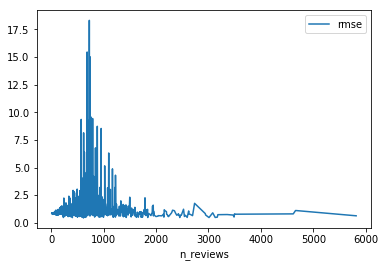

In [30]:
#plot mean RMSE by user count (WITHOUT bins)
rmse_by_reviewcount = n_by_users.groupby('n_reviews').mean()
rmse_by_reviewcount.plot.line()

In [51]:
#plot mean RMSE by user count (with bins)
rmse_by_reviewgroup = n_by_users[['rmse', 'review_group']].groupby('review_group').mean()

rmse_by_reviewgroup.plot.line()

,rmse
review_group,
11-20,0.857098
21-30,0.856729
31-40,0.835981
41-50,0.880876
51-100,0.893078
101-200,0.949864
201-500,1.077986
501-1000,2.135085
1001-2000,1.108471
